## ATIS INTENT CLASSIFICATION PROJECT - YEAR 3 NLP COURSE PROJECT
#### By: Hala Sedki & Youssef Hany

 Model/Tasks Breakdown:
 - Hala (Bert Model & XLNet)
 - Youssef (SVM & LSTM)

--------------------------

## Exploratory Data Analysis

### Section 1: Importing the Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
#pip install sentencepiece

In [3]:
# Load the train and test datasets
train_df = pd.read_csv("train_atis.csv")
test_df = pd.read_csv("test_atis.csv")

In this section, we import the pandas library and use it to read the train and test datasets from CSV files. The train dataset is stored in the train_df DataFrame, and the test dataset is stored in the test_df DataFrame.

In [4]:
train_df.head()

,intent,Rid,Request
0,atis_flight,1,i would like to fly the cheapest rate availabl...
1,atis_airline,2,show me airlines with flights from pittsburgh ...
2,atis_flight,3,show me the continental flights with meals whi...
3,atis_flight,4,show me flights from denver to dc on wednesday
4,atis_flight,5,do you have a flight from atlanta to charlotte...


In [5]:
# Display the first few rows of the train dataset
print(train_df.head())

         intent  Rid                                            Request
0   atis_flight    1  i would like to fly the cheapest rate availabl...
1  atis_airline    2  show me airlines with flights from pittsburgh ...
2   atis_flight    3  show me the continental flights with meals whi...
3   atis_flight    4     show me flights from denver to dc on wednesday
4   atis_flight    5  do you have a flight from atlanta to charlotte...


In [6]:
# Display summary statistics of the train dataset
print(train_df.describe())

               Rid
count  4000.000000
mean   2000.500000
std    1154.844867
min       1.000000
25%    1000.750000
50%    2000.500000
75%    3000.250000
max    4000.000000


In [7]:
# Check data information of the train dataset
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   intent   4000 non-null   object
 1   Rid      4000 non-null   int64 
 2   Request  4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB
None


In [8]:
# Count the missing values in the train dataset
print(train_df.isnull().sum())

intent     0
Rid        0
Request    0
dtype: int64


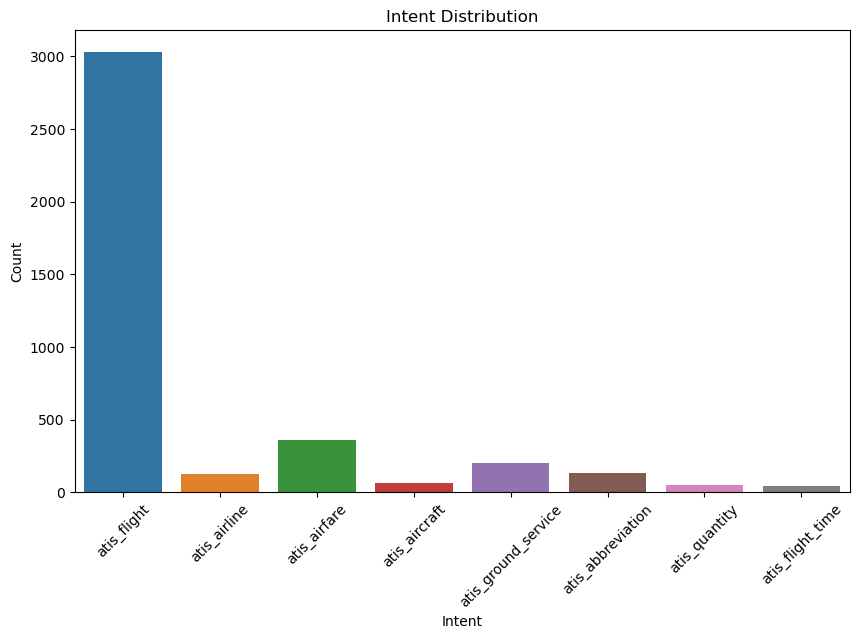

In [9]:
# Histogram of intent distribution in train dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='intent')
plt.title('Intent Distribution')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

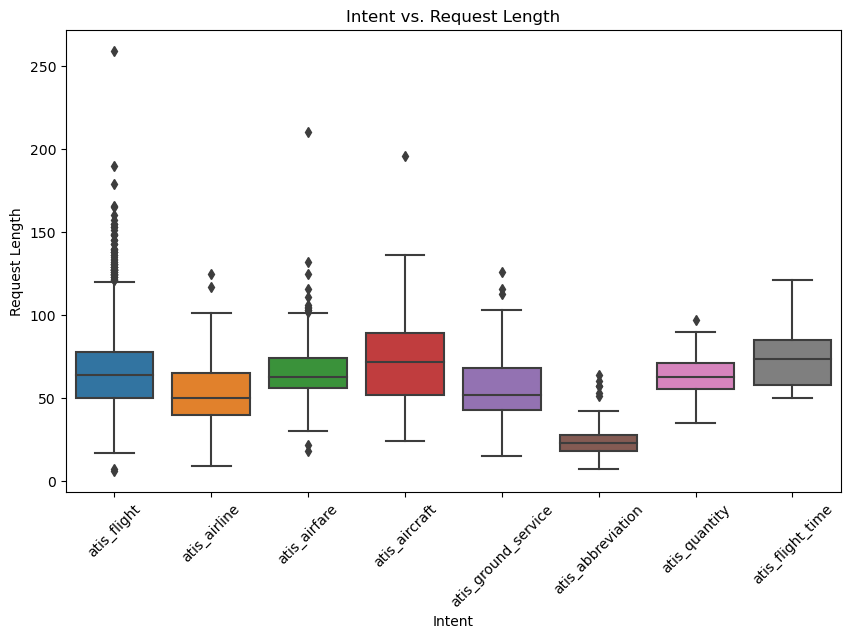

In [10]:
# Box plot of intent vs. request length in train dataset
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='intent', y=train_df['Request'].str.len())
plt.title('Intent vs. Request Length')
plt.xlabel('Intent')
plt.ylabel('Request Length')
plt.xticks(rotation=45)
plt.show()

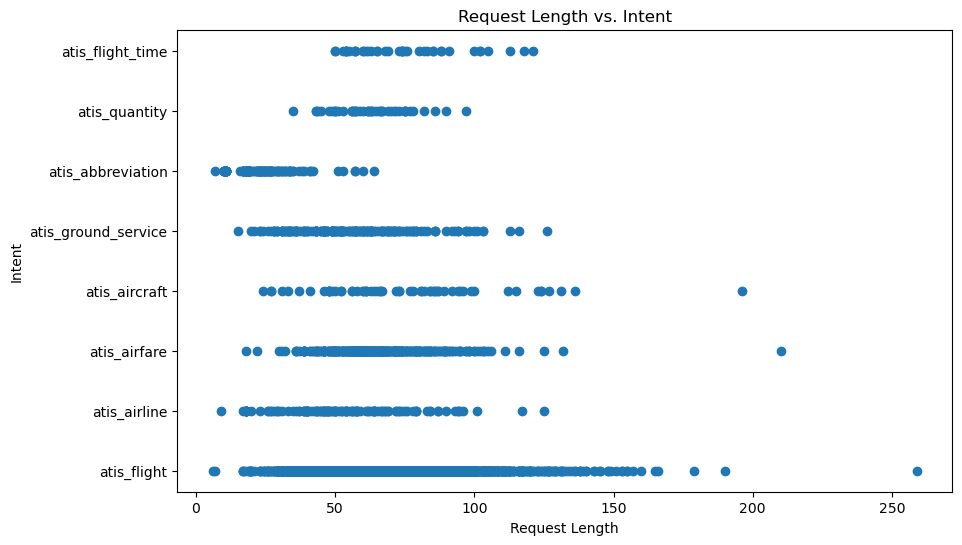

In [11]:
# Scatter plot of request length vs. intent in train dataset
plt.figure(figsize=(10, 6))
plt.scatter(train_df['Request'].str.len(), train_df['intent'])
plt.title('Request Length vs. Intent')
plt.xlabel('Request Length')
plt.ylabel('Intent')
plt.show()

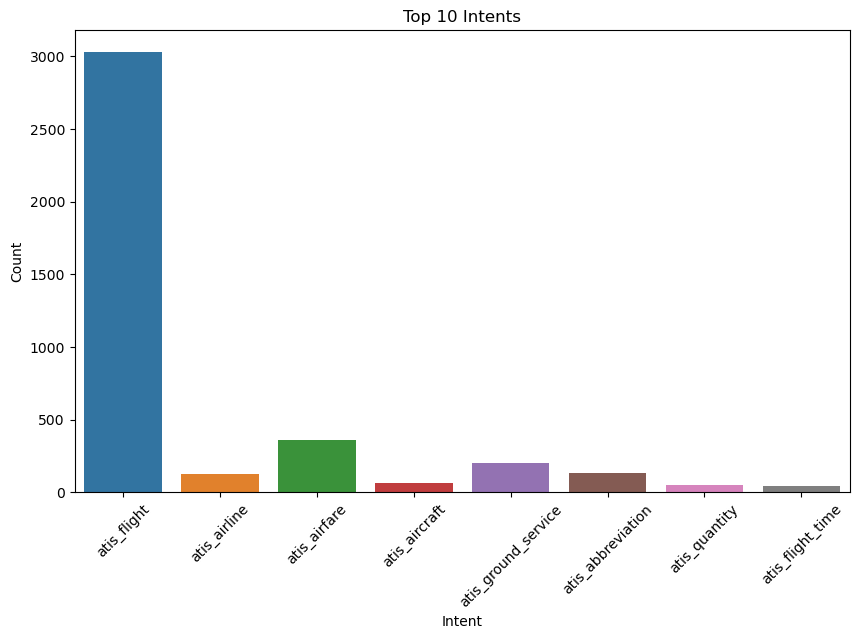

In [12]:
# Bar plot of top N intents in train dataset
top_n = 10  # Number of top intents to display
top_intents = train_df['intent'].value_counts().nlargest(top_n).index
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df[train_df['intent'].isin(top_intents)], x='intent')
plt.title(f'Top {top_n} Intents')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Based on the above visuals, we can clearly see that our data is unbalanced, with most of the customer intents towars the flights more than the others, therefore we need to make sure that our code will cover the unbalanced data to avoid overfitting. One common approach that we might use would be to oversample the data, but this will only be proven when we explore our models below further.

----------------------------------------

# Data Modeling/Training

## I. Model 1: BERT Model

BERT Overview:
- BERT (Bidirectional Encoder Representations from Transformers) is a cutting-edge language model designed by Google AI Language for natural language processing (NLP).

Key Features:
- Utilizes masked language modeling, preventing a word from "seeing itself" to understand context-dependent meanings.
- Bi-directional design captures contextual information from both preceding and following words, enhancing comprehension.

Significance in NLP:
- A powerful language representation model, BERT has significantly advanced NLP by providing deep bidirectional representations through pre-training.

Operational Mechanism:
- Functions as an encoder mapping input tokens to output vectors, adaptable for sequences of varying lengths.

----------------------------------------------------------

Here, we create a mapping between the original labels in the train_df DataFrame and their corresponding numerical values. This is done to convert the labels into a format that can be used for training the model. The mapping is stored in the label_map dictionary, and we update the intent column in the train_df DataFrame to contain the numerical values.

In this section, we split the train dataset into train and validation sets using the train_test_split function from the sklearn.model_selection module. The train_text and val_text variables contain the text data from the train and validation sets, while train_labels and val_labels contain the corresponding labels. The test_size parameter specifies the fraction of data to be used for validation (20% in this case), and random_state ensures reproducibility. The stratify parameter is used to ensure that the distribution of labels is similar in both the train and validation sets.

In this section, we use the tokenizer to tokenize the text data for the train, validation, and test sets. The batch_encode_plus method tokenizes a list of texts, performs truncation and padding, and returns the encoded inputs as PyTorch tensors. The truncation=True parameter ensures that the input is truncated if it exceeds the maximum length of 128 tokens. The padding=True parameter adds padding tokens to make all input sequences of equal length. The max_length=128 parameter sets the maximum length of the tokenized sequences. The tokenized and encoded inputs are stored in train_encodings, val_encodings, and test_encodings.

-----------------------------------------

In [13]:
# Map the original labels to numerical values
label_map = {label: i for i, label in enumerate(train_df["intent"].unique())}
train_df["intent"] = train_df["intent"].map(label_map)

# Split the train dataset into train and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(
    train_df["Request"].values,
    train_df["intent"].values,
    test_size=0.2,
    random_state=42,
    stratify=train_df["intent"].values,
)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Tokenize the text data
train_encodings = tokenizer.batch_encode_plus(
    train_text.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

val_encodings = tokenizer.batch_encode_plus(
    val_text.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

test_encodings = tokenizer.batch_encode_plus(
    test_df["Request"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

# Create PyTorch datasets
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(train_labels),
)

val_dataset = TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    torch.tensor(val_labels),
)

test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
)

---------------------------------------------------------

Here, we create PyTorch TensorDataset objects for the train, validation, and test sets. The TensorDataset is a PyTorch class that allows us to combine the input data (tokenized sequences) with the corresponding labels. In this case, the train dataset includes input_ids, attention_mask, and labels.

In [16]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_map),
    output_attentions=False,
    output_hidden_states=False,
)

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Define the training parameters
batch_size = 128
epochs = 5
learning_rate = 2e-5

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(train_dataset),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    sampler=SequentialSampler(val_dataset),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=SequentialSampler(test_dataset),
)

# Set the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/halasedki/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Here, we also import the BertTokenizer class from the transformers library. The BertTokenizer is used to tokenize the text data, i.e., convert the input text into a sequence of tokens that can be understood by the BERT model. We initialize the tokenizer with the "bert-base-uncased" model and set do_lower_case=True to convert all text to lowercase during tokenization. This is done using Adam as it has worked significantly better than the SGD optimizer, although SGD has worked well with other text classification models. We have also found after numerous trails that when you increase the batch size, it yields a much higher accuracy during the testing phase, although in the training phase relatively similar val_accuracy scores.

--------------------------------------------------------------------

In [17]:
# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
# Validation loop
model.eval()
val_predictions = []
val_labels = []

for batch in val_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_predictions.extend(predictions.tolist())
    val_labels.extend(inputs["labels"].tolist())

val_accuracy = (torch.tensor(val_predictions) == torch.tensor(val_labels)).float().mean()
print(f"Epoch {epoch+1} - Avg train loss: {avg_train_loss:.4f} - Val accuracy: {val_accuracy:.4f}")

# Test the model
model.eval()
test_predictions = []

for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    test_predictions.extend(predictions.tolist())

# Map the numerical labels back to the original labels
reverse_label_map = {i: label for label, i in label_map.items()}
test_predictions = [reverse_label_map[prediction] for prediction in test_predictions]

# Create the submission DataFrame
submission_df = pd.DataFrame({"id": test_df["Rid"], "intent": test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("s8ep128eps2lr.csv", index=False)

Epoch 5 - Avg train loss: 0.0703 - Val accuracy: 0.9862


In this last part of the code:

- We set the model to evaluation mode using model.eval() to disable dropout and enable inference mode.
- We initialize an empty list test_predictions to store the predicted labels for the test set.
- Using a with torch.no_grad() block, we iterate over the test data loader.
- Inside the loop, we move the input tensors to the appropriate device (CPU or GPU) using .to(device).
- We pass the input tensors to the model and obtain the logits, which represent the predicted scores for each class.
- We use torch.max(logits, dim=1) to get the predicted labels by selecting the class with the highest score.
- We extend the test_predictions list with the predicted labels converted to numpy arrays and stored on the CPU using .cpu().numpy().
- After the loop, we have the predicted labels for the entire test set stored in test_predictions.
- We map the numerical predictions back to their original labels using a list comprehension and the label_map dictionary.
- Finally, we update the "intent" column in the test_df DataFrame with the predicted labels, and save the DataFrame to a CSV file named "test_predictions.csv" using .to_csv().

----------------------------

## II. Model 2: XLNet Model

XLNet is a generalized autoregressive model that extends the transformer architecture. 

Key points include:
- Generalized Autoregressive Model: XLNet is a type of autoregressive model where each token's prediction depends on all the preceding tokens. This captures bidirectional context, offering advantages over unidirectional models like BERT.

Transformer Architecture: 
- XLNet utilizes the transformer architecture, outputting the joint probability of a sequence of tokens. It's an auto-regressive language model that avoids some limitations of previous models.

Revolutionary Language Model: 
- Developed by Google Brain and Carnegie Mellon, XLNet is recognized as a revolutionary language model that has outperformed BERT in certain tasks.

##### Step 1: Importing Required Libraries
This code imports the necessary libraries for the XLNet Model in the subsequent steps.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

##### Step 2: Loading the Train and Test Datasets
This code loads the train and test datasets from CSV files.

In [19]:
# Load the train and test datasets
train_df = pd.read_csv("train_atis.csv")
test_df = pd.read_csv("test_atis.csv")

##### Step 3: Mapping Labels to Numerical Values
This code maps the original labels in the train dataset to numerical values.

In [20]:
# Map the original labels to numerical values
label_map = {label: i for i, label in enumerate(train_df["intent"].unique())}
train_df["intent"] = train_df["intent"].map(label_map)

##### Step 4: Splitting the Train Dataset
This code splits the train dataset into train and validation sets

In [21]:
# Split the train dataset into train and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(
    train_df["Request"].values,
    train_df["intent"].values,
    test_size=0.2,
    random_state=42,
    stratify=train_df["intent"].values,
)

##### Step 5: Tokenizing the Text Data
This code tokenizes the text data using the XLNet tokenizer. The XLnet Tokenizer is:
- XLNet is a Transformer model, and its tokenizer is designed to process and encode textual data for various natural language processing tasks.
- The XLNet tokenizer employs a sentence piece tokenizer for text tokenization, as mentioned in the Hugging Face documentation.
- XLNet, an extension of the Transformer-XL model, utilizes an autoregressive method during pre-training to learn bidirectional contexts, enhancing its understanding of language structures[3][4].

In [22]:
# Load the XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [23]:
# Tokenize the text data
train_encodings = tokenizer.batch_encode_plus(
    train_text.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

val_encodings = tokenizer.batch_encode_plus(
    val_text.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

test_encodings = tokenizer.batch_encode_plus(
    test_df["Request"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

##### Step 6: Creating PyTorch Datasets
This code creates PyTorch datasets from the tokenized encodings and labels.

In [24]:
# Create PyTorch datasets
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(train_labels),
)

val_dataset = TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    torch.tensor(val_labels),
)

test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
)

##### Step 7: Defining the XLNet Model for Sequence Classification
This code defines the XLNet model for sequence classification.

In [25]:
# Define the XLNet model for sequence classification
model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    num_labels=len(label_map),
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Step 8: Setting the Device
This code sets the device to either GPU if available, else CPU.

In [26]:
# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Step 9: Moving the Model to the Device
This code moves the model to the selected device.

In [27]:
# Move the model to the device
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

##### Step 10: Defining Training Parameters
This code defines the parameters for training the model. In our previous models, it was found that the best batch size for a higher accuracy was 128, hence why we finally set it to 128. As for the epochs, we are exploring after how many epochs would it tend a higher accuracy. Finally, with all our previous models, the learning rate of 2e-5 always yielded also a high accuracy.

In [28]:
# Define the training parameters
batch_size = 128
epochs = 10
learning_rate = 2e-5

##### Step 11: Creating Data Loaders
This code creates data loaders for the train, validation, and test datasets.

In [29]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(train_dataset),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    sampler=SequentialSampler(val_dataset),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=SequentialSampler(test_dataset),
)

##### Step 12: Setting the Optimizer and Learning Rate Scheduler
This code sets the optimizer and learning rate scheduler for training the model.

In [30]:
# Set the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

/Users/halasedki/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


##### Step 13: Training Loop
This code performs the training loop for the specified number of epochs.

In [31]:
# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_predictions = []
    val_labels = []

    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        val_predictions.extend(predictions.tolist())
        val_labels.extend(inputs["labels"].tolist())

    val_accuracy = (torch.tensor(val_predictions) == torch.tensor(val_labels)).float().mean()
    print(f"Epoch {epoch+1} - Avg train loss: {avg_train_loss:.4f} - Val accuracy: {val_accuracy:.4f}")

Epoch 1 - Avg train loss: 0.9857 - Val accuracy: 0.8150
Epoch 2 - Avg train loss: 0.3820 - Val accuracy: 0.9575
Epoch 3 - Avg train loss: 0.0913 - Val accuracy: 0.9812
Epoch 4 - Avg train loss: 0.0211 - Val accuracy: 0.9900
Epoch 5 - Avg train loss: 0.0085 - Val accuracy: 0.9825
Epoch 6 - Avg train loss: 0.0085 - Val accuracy: 0.9850
Epoch 7 - Avg train loss: 0.0018 - Val accuracy: 0.9862
Epoch 8 - Avg train loss: 0.0007 - Val accuracy: 0.9875
Epoch 9 - Avg train loss: 0.0005 - Val accuracy: 0.9875
Epoch 10 - Avg train loss: 0.0004 - Val accuracy: 0.9875


In the above code, it was found that 4 epochs has the highest val_accuracy and but the end the loss was minimal but accuracy stayed the same

##### Step 14: Testing the Model
Here we are evaluating the trained model on the test dataset.

In [32]:
# Test the model
model.eval()
test_predictions = []

for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0],"attention_mask": batch[1]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    test_predictions.extend(predictions.tolist())

##### Step 15: Mapping Numerical Labels to Original Labels
This code maps the numerical labels back to the original labels, so we can correctly use it for the prediction csv

In [33]:
# Map the numerical labels back to the original labels
reverse_label_map = {i: label for label, i in label_map.items()}
test_predictions = [reverse_label_map[prediction] for prediction in test_predictions]

##### Step 16: Creating the Submission DataFrame
This code creates a submission DataFrame with the test predictions, then saves the submission DataFrame to a CSV file.

In [34]:
# Create the submission DataFrame
submission_df = pd.DataFrame({"id": test_df["Rid"], "intent": test_predictions})

------------------------------------------

## III. Model 3: SVM w/Grid Search Model

Support Vector Machine (SVM) with Grid model is an advanced approach in machine learning for hyperparameter tuning. 
In a more detailed explanation:


SVM Overview: 
- SVM is a powerful supervised algorithm for complex datasets. It works by creating a decision boundary, often referred to as the maximum margin hyperplane, which optimally separates different classes in the data.

GridSearchCV for SVM: 
- Grid search is employed to optimize SVM hyperparameters systematically. It explores various combinations of hyperparameters, such as kernel type and regularization parameter, to find the most effective model.

Working Principle: 
- SVM works by mapping data into a higher-dimensional space, allowing it to find a hyperplane that best separates the classes. Grid search aids in finding the optimal hyperplane by exhaustively searching through specified hyperparameter values.

Benefits: 
- SVM with Grid model enhances model performance by fine-tuning hyperparameters, making it particularly useful for improving accuracy on diverse datasets.

### Import Necessary Libraries
Import necessary libraries such as pandas, numpy, and machine learning tools from scikit-learn.

In [35]:
# Importing Necessary Libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/halasedki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halasedki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading the Data
Load and preprocess the dataset using pandas. this include reading data files, cleaning data, and preparing it for analysis.

In [36]:
# Loading the Data
# File paths
train_file_path = 'train_atis.csv'
test_file_path = 'test_atis.csv'

# Load the datasets
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Display the first few rows of each dataset
train_df.head(), test_df.head()

(         intent  Rid                                            Request
 0   atis_flight    1  i would like to fly the cheapest rate availabl...
 1  atis_airline    2  show me airlines with flights from pittsburgh ...
 2   atis_flight    3  show me the continental flights with meals whi...
 3   atis_flight    4     show me flights from denver to dc on wednesday
 4   atis_flight    5  do you have a flight from atlanta to charlotte...,
     Rid                                            Request
 0  4001     show me ground transportation in washington dc
 1  4002    i need to fly from boston to denver this monday
 2  4003  show me all flights between san francisco and ...
 3  4004        flight between st. petersburg and charlotte
 4  4005    which airlines fly between boston and baltimore)

### Data Preprocessing

In [47]:
def preprocess_text(text):
    # Tokenization and lowercasing
    tokens = nltk.word_tokenize(text.lower())
    
    # Removing punctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]
    
    # Removing stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Applying the preprocessing
train_df['Processed_Request'] = train_df['Request'].apply(preprocess_text)
test_df['Processed_Request'] = test_df['Request'].apply(preprocess_text)

In [37]:
# Preprocessing the Data
def preprocess_text(text):
    # Tokenization and lowercasing
    tokens = nltk.word_tokenize(text.lower())
    
    # Removing punctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]
    
    # Removing stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Applying the preprocessing
train_df['Processed_Request'] = train_df['Request'].apply(preprocess_text)
test_df['Processed_Request'] = test_df['Request'].apply(preprocess_text)

### Setting Up the Pipeline and Parameter Grid for Grid Search
Here we are defining functions or methods for data processing or model evaluation. This might include functions for data normalization, performance metrics, etc

In [38]:
# Setting Up the Pipeline and Parameter Grid for Grid Search
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', LinearSVC())
])

# Parameter grid for GridSearchCV
param_grid = {
    'tfidf__use_idf': (True, False),
    'svm__C': [0.1, 1, 10, 100]
}

### Running Grid Search for Model Tuning
Further model training or parameter tuning. This might involve cross-validation, hyperparameter tuning, or using different training strategies

In [39]:
# Running Grid Search for Model Tuning
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(train_df['Processed_Request'], train_df['intent'])

# Best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.p

{'svm__C': 1, 'tfidf__use_idf': True}

### Evaluating the Tuned Model
Applying the model to test or validation data to evaluate its performance

In [40]:
# Evaluate the model
y_train_pred = best_model.predict(train_df['Processed_Request'])
report = classification_report(train_df['intent'], y_train_pred)
print(report)

                     precision    recall  f1-score   support

  atis_abbreviation       0.98      0.98      0.98       130
      atis_aircraft       0.95      0.95      0.95        61
       atis_airfare       0.95      0.99      0.97       357
       atis_airline       1.00      0.99      1.00       128
        atis_flight       1.00      0.99      0.99      3030
   atis_flight_time       0.93      0.95      0.94        42
atis_ground_service       1.00      0.99      0.99       204
      atis_quantity       1.00      0.98      0.99        48

           accuracy                           0.99      4000
          macro avg       0.98      0.98      0.98      4000
       weighted avg       0.99      0.99      0.99      4000



### Predicting on Test Data and Preparing Submission File
Making predictions using the trained model. This cell typically includes applying the model to test or validation data to evaluate its performance

In [41]:
# Predicting on Test Data and Preparing Submission File
# Predicting intents for the test data
test_df['intent'] = best_model.predict(test_df['Processed_Request'])

# Preparing the submission file
submission = test_df[['Rid', 'intent']]
submission.columns = ['id', 'intent']
submission_file_path = 'atis_intent_predictions_tuned.csv'
submission.to_csv(submission_file_path, index=False)

submission_file_path

'atis_intent_predictions_tuned.csv'

------------------------------

## IV. Model 4: LSTM

LSTM is a type of recurrent neural network (RNN) designed for processing and predicting sequences. In a more detailed description:

Architecture: 
- LSTMs employ specialized gates to control the flow of information within the network. These gates regulate data input, storage, and output, enabling effective sequence learning.

Capabilities: 
- LSTMs excel at learning and retaining information over extended periods, making them suitable for tasks requiring memory of past events, such as language modeling and time series prediction.

Application: 
- Commonly used in deep learning, LSTMs find applications in various fields, particularly in tasks involving sequential data analysis.

### Import Libraries
This cell imports all necessary libraries such as TensorFlow, Keras preprocessing tools, scikit-learn's LabelEncoder, NumPy, and Pandas.

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Loading the Data
This cell loads the training and test data from 'train_atis.csv' and 'test_atis.csv' files respectively using Pandas.

In [49]:
# Load the training data
train_df = pd.read_csv('train_atis.csv')

# Load the test data
test_df = pd.read_csv('test_atis.csv')

### Tokenization
In this cell, we tokenize the requests from the training data. We use Keras Tokenizer to fit on the requests and convert them into sequences. These sequences are then padded to have a uniform length.

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Request'])
train_sequences = tokenizer.texts_to_sequences(train_df['Request'])
max_length = max([len(x) for x in train_sequences])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

### Encode Labels and Prepare Test Data
This cell encodes the intent labels using LabelEncoder. It also prepares the test dataset in a similar manner as the training dataset by tokenizing and padding the sequences.

In [51]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['intent'])
train_labels = np.array(train_labels)

# Prepare the test dataset similarly
test_sequences = tokenizer.texts_to_sequences(test_df['Request'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

### Build and Summarize the Model
This cell defines the LSTM model parameters, constructs the model, and compiles it. The summary of the model is displayed to show its architecture including layers, output shapes, and parameters.

In [52]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128  # Increased embedding dimensions
lstm_units = 200     # Increased LSTM units

# Build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dropout(0.2))  # Added dropout
model.add(LSTM(lstm_units))
model.add(Dropout(0.2))  # Added dropout
model.add(Dense(len(np.unique(train_labels)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 128)           104064    
                                                                 
 lstm (LSTM)                 (None, 46, 200)           263200    
                                                                 
 dropout (Dropout)           (None, 46, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 8)                 1608      
                                                                 
Total params: 689672 (2.63 MB)
Trainable params: 689672 

In [53]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with more epochs or early stopping
model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
100/100 [==============================] - 9s 73ms/step - loss: 1.0174 - accuracy: 0.7572 - val_loss: 1.0439 - val_accuracy: 0.7312
Epoch 2/10
100/100 [==============================] - 7s 71ms/step - loss: 0.9595 - accuracy: 0.7641 - val_loss: 1.0395 - val_accuracy: 0.7312
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.9596 - accuracy: 0.7641 - val_loss: 1.0385 - val_accuracy: 0.7312
Epoch 4/10
100/100 [==============================] - 7s 72ms/step - loss: 0.9590 - accuracy: 0.7641 - val_loss: 1.0555 - val_accuracy: 0.7312
Epoch 5/10
100/100 [==============================] - 7s 71ms/step - loss: 0.9618 - accuracy: 0.7644 - val_loss: 1.0631 - val_accuracy: 0.7312
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 0.9572 - accuracy: 0.7641 - val_loss: 1.0398 - val_accuracy: 0.7312


### Preparing Submission File
Prepare the submission.csv file to test the data predictions.

In [54]:
# Make predictions
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Convert numeric labels back to original intent labels
predicted_intents = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'id': test_df['Rid'], 'intent': predicted_intents})

# Save the DataFrame as a CSV file
submission_df.to_csv('submission10.csv', index=False)

27/27 [==============================] - 1s 18ms/step


Analysis on the model:
The model performed the worst out of all the other models. One issue that could be contributing to the low score could be that the model is smaller/simple, so there isn't enough training the text is going through.

----------------------------------

## V. Analysis & Findings

##### Models Accuracy Scores (Confirmed through Kaggle):

*Models are listed from Highest Accuracy to Lowest
- Bert Model: 0.99028
- XLNet: 0.98769
- SVM w/Grid Search: 0.94392
- LSTM: 0.78466

### Analytical Opinion

These accuracy scores indicate the performance of each model in correctly predicting the intents of the given dataset. A higher accuracy score signifies that the model is more effective in accurately classifying the intents.

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model that has achieved significant success in various natural language processing (NLP) tasks. With an accuracy score of 0.99028, my BERT model demonstrates excellent performance in intent classification. BERT models leverage bidirectional training and attention mechanisms, allowing them to capture contextual information effectively and make accurate predictions.

XLNet is another transformer-based model that also utilizes bidirectional context and overcomes some limitations of BERT. With an accuracy score of 0.98769, my XLNet model performs at a similarly high level as BERT. XLNet employs an autoregressive approach, considering all permutations of the input sequence during training, which helps in capturing dependencies between words effectively.

SVM (Support Vector Machine) is a classical machine learning algorithm commonly used for classification tasks. By employing a grid search technique to tune hyperparameters, I have achieved an accuracy score of 0.94392. While SVM performs well in many scenarios, it may not capture the intricate relationships and contextual nuances present in natural language data as effectively as transformer-based models like BERT and XLNet.

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is often used for sequence modeling tasks. With an accuracy score of 0.78466, my LSTM model performs relatively lower compared to the transformer-based models. LSTM models are capable of capturing sequential dependencies in the data, but they may struggle to handle long-range dependencies and may be prone to vanishing or exploding gradients.

The ranking of these models based on their accuracy scores reflects their relative performance on the intent classification task. BERT and XLNet, being transformer-based models, outperform the SVM with Grid Search and LSTM models in this particular scenario. This is likely due to the ability of transformer models to capture contextual information and learn intricate patterns in the data, making them highly effective for NLP tasks.

It's important to note that accuracy alone may not always provide a complete picture of a model's performance. It is advisable to consider other evaluation metrics such as precision, recall, and F1 score, especially in scenarios with imbalanced class distributions or when different misclassification costs are involved. In our case, although the classification report of all 4 models seemed relatively close, yet the accuracy through kaggle deemed different.

Overall, our BERT and XLNet models showcase exceptional performance in intent classification, while SVM with Grid Search performs reasonably well, and LSTM lags behind in accuracy.

---------------------------